# Example: using a different force field

Here we show how to use MDPOW to calculate partition coefficients using an force field that isn't included in the package. To follow along, install `jupyter` in your `mdpow` environment.

To implement a new force field, you will need:

* `ITP` files for the molecule, the solvents, ions and also the general atom type definitions file (usually just named after the force field itself).
* `MDP` files for the energy minimisation, initial relaxation, NPT ensemble run and free energy calculation.
* Structure files (`.gro` or `.pdb`) for the solute and non-aqueous solvent. If you are using a type of water that does not come bundled with GROMACS, like in this example, you will also need to create an equilibrated box of pure water.

The first thing we'll do is to download the files we need for Martini 3.0.

In [1]:
from pathlib import Path
from typing import Optional

import requests as req


HERE = Path(".")
MARTINI_FF = HERE / "martini.ff"
MARTINI_FF.mkdir(exist_ok=True)

MARTINI_ITP = MARTINI_FF / "forcefield.itp"
MARTINI_IONS = MARTINI_FF / "martini_v3.0.0_ions_v1.itp"
MARTINI_SMALL_MOLS = MARTINI_FF / "martini_v3.0.0_small_molecules_v1.itp"
MARTINI_SOLVENTS = MARTINI_FF / "martini_v3.0.0_solvents_v1.itp"
BENZENE_ITP = MARTINI_SMALL_MOLS

MARTINI_WATER = HERE / "water.gro"
MARTINI_OCTANOL = HERE / "octanol.gro"
MARTINI_BENZENE = HERE / "benzene.pdb"

EM_FILE = HERE / "em.mdp"
EQ_FILE = HERE / "eq.mdp"
RUN_FILE = HERE / "run.mdp"


def download_file(
    url: str, out: Optional[Path] = None, chunk_size: int = 128, overwrite: bool = False
):
    """Utility function to download files."""
    if out is None:
        out = HERE / Path(url).name

    if out.exists() and not overwrite:
        return

    r = req.get(url, stream=True)
    r.raise_for_status()

    with out.open("wb") as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)


DOWNLOADS = {
    MARTINI_ITP: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0.itp",
    MARTINI_IONS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_ions_v1.itp",
    MARTINI_SMALL_MOLS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_small_molecules_v1.itp",
    MARTINI_SOLVENTS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_solvents_v1.itp",
}

for fname, url in DOWNLOADS.items():
    download_file(url, fname)

This should have downloaded several files to your workspace.

We also need to make a `watermodels.dat` file in the `martini.ff` subdirectory.


In [2]:
WATERMODEL_DAT = MARTINI_FF / "watermodels.dat"

WATERMODEL_DAT.write_text("martini-water\tMARTINI-WATER\tMartini default water model.")

56

Next, we set up the files for the Martini 3.0 forcefield.

In [15]:
from mdpow.forcefields import Forcefield, GromacsSolventModel

MARTINI = Forcefield(
    "Martini",
    solvent_models={
        "octanol": GromacsSolventModel(
            identifier="octanol",
            itp=MARTINI_SOLVENTS.absolute(),
            coordinates=str(MARTINI_OCTANOL.absolute()),
            forcefield="Martini",
        ),
    },
    forcefield_dir=MARTINI_FF.absolute(),
    ions_itp=MARTINI_IONS.absolute(),
    default_water_itp=MARTINI_SOLVENTS.absolute(),
    default_water_model="martini-water",
    water_models={
        "martini-water": GromacsSolventModel(
            identifier="martini-water",
            itp=MARTINI_SOLVENTS.absolute(),
            coordinates=str(MARTINI_WATER.absolute()),
            forcefield="Martini",
        ),
    },
)

In [4]:
from dataclasses import asdict

for solvent_name, solvent_model in MARTINI.solvent_models.items():
    print(solvent_name)
    print(asdict(solvent_model))

octanol
{'identifier': 'octanol', 'name': 'OCTANOL', 'itp': PosixPath('/home/awsm/MDPOW/doc/examples/martini/martini.ff/martini_v3.0.0_solvents_v1.itp'), 'coordinates': PosixPath('/home/awsm/MDPOW/doc/examples/martini/octanol.gro'), 'description': None, 'forcefield': 'Martini'}


In [5]:
from mdpow.equil import WaterSimulation

sim = WaterSimulation(
    molecule="BENZ",
    ff_class=MARTINI,
    mdp={
        "energy_minimize": str(EM_FILE.absolute()),
        "MD_relaxed": str(EQ_FILE.absolute()),
        "MD_NPT": str(EQ_FILE.absolute()),
        "MD_restrained": str(RUN_FILE.absolute()),
    },
    distance=3.0,
)
sim.topology(str(BENZENE_ITP))
sim.solvate(struct=MARTINI_BENZENE, maxwarn=1)
sim.energy_minimize(maxwarn=1)
sim.MD_relaxed(runtime=1e3, dt=0.01)

mdpow.equil : INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top] Created topology 'system.top' that includes 'martini_v3.0.0_small_molecules_v1.itp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation] Solvating with water '/home/awsm/MDPOW/doc/examples/martini/water.gro'...
                     :-) GROMACS - gmx editconf, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation
Command line:
  gmx editconf -f /home/awsm/MDPOW/doc/examples/martini/benzene.pdb -o boxed.gro -bt dodecahedron -d 3.0


Back Off! I just backed up boxed.gro to ./#boxed.gro.11#

GROMACS reminds you: "The loveliest theories are being overthrown by these damned experiments; it is no fun being a chemist any more." (Justus von Liebig, letter to J.J. Berzelius 1834)

                     :-) GROMACS - gmx solvate, 2023.2 (-:

Executable:   /usr/local

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3 atoms
Volume: 4050 nm^3, corresponds to roughly 1822500 electrons
No velocities found
    system size :  0.210  0.160  0.248 (nm)
    diameter    :  0.270               (nm)
    center      :  2.987  0.606  2.315 (nm)
    box vectors : 15.000 15.000 18.000 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :4050.00               (nm^3)
    shift       :  1.716  4.097 -0.098 (nm)
new center      :  4.703  4.703  2.217 (nm)
new box vectors :  6.270  6.270  6.270 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 174.32               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functiona

gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation] After solvation: total charge qtot = 0 = 0
gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     Building the main index file 'main.ndx'...
                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation
Command line:
  gmx make_ndx -f ionized.tpr -o main.ndx


Reading structure file
Reading file ionized.tpr, VERSION 2023.2 (single precision)
Reading file ionized.tpr, VERSION 2023.2 (single precision)

Back Off! I just backed up main.ndx to ./#main.ndx.22#

GROMACS reminds you: "You still have to climb to the shoulders of the giants" (Vedran Miletic)

                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/lo

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 4: '__main__'
Select group for output
Selected 0: 'System'


atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 642 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 643 i

Setting the LD random seed to 1853841179

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom n

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 642 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 643 i

Setting the LD random seed to -561519253

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom n


Back Off! I just backed up em.log to ./#em.log.11#
Reading file em.tpr, VERSION 2023.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 


Back Off! I just backed up em.trr to ./#em.trr.11#

Back Off! I just backed up em.edr to ./#em.edr.11#

Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =         1000
Step=    0, Dmax= 1.0e-02 nm, Epot=  9.59019e+06 Fmax= 1.69656e+07, atom= 149
Step=    1, Dmax= 1.0e-02 nm, Epot=  6.21902e+06 Fmax= 6.01139e+06, atom= 478
Step=    2, Dmax= 1.2e-02 nm, Epot=  3.58839e+06 Fmax= 2.70774e+06, atom= 17
Step=    3, Dmax= 1.4e-02 nm, Epot=  2.18086e+06 Fmax= 1.08770e+06, atom= 1305
Step=    4, Dmax= 1.7e-02 nm, Epot=  1.25600e+06 Fmax= 5.29430e+05, atom= 1493
Step=    5, Dmax= 2.1e-02 nm, Ep

Setting the LD random seed to -1881604097

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.132 nm, buffer size 0.032 nm

Set rlist, assuming 4x4 atom pair-list, to 1.108 nm, buffer size 0.008 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 1 Mb of data


{'struct': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.gro',
 'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top',
  '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top']}

In [6]:
import gromacs

r = gromacs.run.MDrunner(
    dirname=sim.dirs["MD_relaxed"],
    deffnm="md",
    c="md.pdb",
    cpi=True,
    v=True,
)
r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 50, rlist from 1.107 to 1.268

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in water'
100000 steps,   1000.0 ps (continuing from step 100000,   1000.0 ps).

Writing final coordinates.

Back Off! I just backed up md.pdb to ./#md.pdb.11#
step 100000, remaining wall clock time:     0 s          
NOTE: 42 % of the run time was spe

0

In [7]:
sim.MD(
    runtime=10e3, qscript=["local.sh"], dt=0.02
)

r = gromacs.run.MDrunner(
    dirname=sim.dirs["MD_NPT"], deffnm="md", c="md.pdb", cpi=True, v=True
)
r.run()  # runs mdrun in the python shell

mdpow.equil : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.gro').
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp'
gromacs.cbook: INFO     editing mdp = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp': dict_keys(['nsteps', 'dt', 'pp', 't', 'include'])
gromacs.cbook: WARNING  Not substituted in 'md.mdp': ['pp', 't']
gromacs.setup: WARNING  Unprocessed mdp option are interpreted as options for grompp:
{'pp': 'processed.top', 't': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.cpt'}
/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/setup.py:635: UsageWarning: Unprocessed mdp option are interpreted a

Setting the LD random seed to -269549605

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.175 nm, buffer size 0.075 nm

Set rlist, assuming 4x4 atom pair-list, to 1.133 nm, buffer size 0.033 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1000 ps

Starting time for run is 0 ps

This run will generate roughly 6 Mb of data


Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 25, rlist from 1.133 to 1.262

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in water'
500000 steps,  10000.0 ps (continuing from step 500000,  10000.0 ps).

Writing final coordinates.

Back Off! I just backed up md.pdb to ./#md.pdb.9#
step 500000, remaining wall clock time:     0 s          
NOTE: 11 % of the run time was spent in pair search,
      you might want to increase nstlist (this has no effect on accuracy)

               Core t (s)   Wall t (s)        (%)
       Time:        0.054        0.014      397.1
                 (ns/day)    (hour/ns)
Performance:      126.362        0.190

GROMACS reminds you: "Philosophy of science is about as usef

0

In [8]:
import mdpow.fep

gwat = mdpow.fep.Ghyd(simulation=sim, runtime=1e+3, mdp=str(RUN_FILE.absolute()))
gwat.setup(dt=0.02, edr=False)

# run multiple simulations on cluster

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

mdpow.fep   : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD

Setting the LD random seed to -30909756

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 15 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Pain is inevitable. Suffering is optional." (Haruki Murakami)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] outp

Setting the LD random seed to -154140945

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 15 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Wait a Minute, aren't You.... ? (gunshots) Yeah." (Bodycount)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] outp

Setting the LD random seed to -1612087323

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 15 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Wait a Minute, aren't You.... ? (gunshots) Yeah." (Bodycount)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] outp

Setting the LD random seed to -20971547

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 15 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "I Quit My Job Blowing Leaves" (Beck)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output runscripts = ['./local

Setting the LD random seed to -71374085

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 15 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "I Quit My Job Blowing Leaves" (Beck)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output runscripts = ['./local.sh']
gromacs.se

Setting the LD random seed to 1173802941

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Welcome to the Power Age" (2 Unlimited)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output runscripts = ['./local.sh']
gromacs

Setting the LD random seed to -1411402275

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Welcome to the Power Age" (2 Unlimited)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output runscripts = ['./local.sh']
gromacs

Setting the LD random seed to -1678026753

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Like other defaulters, I like to lay half the blame on ill-fortune and adverse circumstances" (Mr. Rochester in Jane Eyre by Charlotte Bronte)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output tpr = 'md.tpr'
gromacs.setup: INFO   

Setting the LD random seed to -963675284

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "GROMACS First : Making MD Great Again" (Vedran Miletic)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output runscripts = ['./lo

Setting the LD random seed to -375586905

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "GROMACS First : Making MD Great Again" (Vedran Miletic)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output runscripts = ['./lo

Setting the LD random seed to 1658150910

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "C has the power of assembly language and the convenience of... assembly language." (Dennis Ritchie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FE

Setting the LD random seed to -102768749

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "C has the power of assembly language and the convenience of... assembly language." (Dennis Ritchie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FE

Setting the LD random seed to -1126270785

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "I Have a Bad Case Of Purple Diarrhea" (Urban Dance Squad)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output runscripts = ['./

Setting the LD random seed to -265217

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "I Have a Bad Case Of Purple Diarrhea" (Urban Dance Squad)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output runscripts = ['./

Setting the LD random seed to 2077204442

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Erwin with his psi can do / Calculations quite a few. / But one thing has not been seen / Just what psi really mean." (Felix Bloch)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/aw

Setting the LD random seed to -170917891

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Erwin with his psi can do / Calculations quite a few. / But one thing has not been seen / Just what psi really mean." (Felix Bloch)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/aw

Setting the LD random seed to -1128333313

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "Not everyone is capable of madness; and of those lucky enough to be capable, not many have the courage for it." (August Strindberg)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/aw

Setting the LD random seed to -143274449

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "A scientific truth does not triumph by convincing its opponents and making them see the light, but rather because its opponents eventually die and a new generation grows up that is familiar with it." (Max Planck)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/ma

Setting the LD random seed to 1994323699

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "A scientific truth does not triumph by convincing its opponents and making them see the light, but rather because its opponents eventually die and a new generation grows up that is familiar with it." (Max Planck)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/ma

Setting the LD random seed to -1484915985

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 3 NOTEs

There was 1 WARNING

Back Off! I just backed up md.tpr to ./#md.tpr.1#

GROMACS reminds you: "It always takes longer than you think even when you take Hofstadter's Law into account." (Hofstadter's Law)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/ma

Setting the LD random seed to -170164757

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 17 Mb of data


{'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/pp_system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top'],
 'maxwarn': 1,
 'couple-intramol': 'no',
 'couple_lambda0': 'vdw',
 'couple_lambda1': 'none',
 'sc_alpha': 0.5,
 'sc_power': 1,
 'sc_sigma': 0.3,
 'separate-dhdl-file': 'yes',
 'ref_t': 300.0,
 'gen_temp': 300.0,
 'free_energy': 'yes',
 'couple_moltype': 'BENZ',
 'init_lambda_state': 15,
 'fep_lambdas': array([0.  , 0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.65, 0.7 , 0.75,
        0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'calc_lambda_neighbors': -1}

In [9]:
for dir_ in gwat.fep_dirs():
    r = gromacs.run.MDrunner(
        dirname=dir_, deffnm="md", c="md.pdb", cpi=True, v=True, dhdl="md.xvg"
    )
    r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl md.xvg


                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl md.xvg


Back Off! I just backed up md.log to ./#md.log.1#
Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 20 to 25, rlist from 1.214 to 1.262

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 


Back Off! I just backed up md.xtc to ./#md.xtc.1#

Back Off! I just backed up md.trr to ./#md.trr.1#

Back Off! I just backed up md.edr to ./#md.edr.1#

Back Off! I just backed up md.xvg to ./#md.xvg.1#
starting mdrun 'Compound BENZ in water'
250000 steps,   5000.0 ps.
step 249900, re

mdpow.fep   : INFO     [FEP/water] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/water] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/water] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/water] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/water] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/water] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/water] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/water] Compression complete

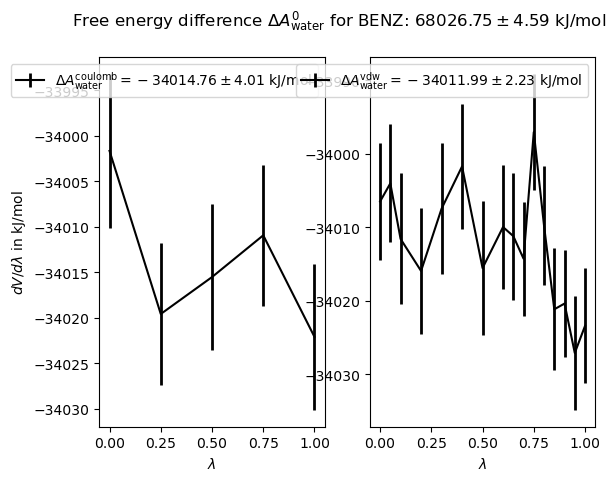

In [10]:
gwat.collect_alchemlyb()
gwat.analyze_alchemlyb()
gwat.plot()

In [16]:
from mdpow.equil import OctanolSimulation

oct_sim = OctanolSimulation(
    molecule="BENZ",
    ff_class=MARTINI,
    mdp={
        "energy_minimize": str(EM_FILE.absolute()),
        "MD_relaxed": str(EQ_FILE.absolute()),
        "MD_NPT": str(EQ_FILE.absolute()),
        "MD_restrained": str(RUN_FILE.absolute()),
    },
    distance=4.0,
)
oct_sim.topology(str(BENZENE_ITP))
oct_sim.solvate(struct=MARTINI_BENZENE, maxwarn=1)
oct_sim.energy_minimize(maxwarn=1)
oct_sim.MD_relaxed(runtime=1e3, dt=0.01)

mdpow.equil : INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top] Created topology 'system.top' that includes 'martini_v3.0.0_small_molecules_v1.itp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation' (newly created)...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation] Solvating with water '/home/awsm/MDPOW/doc/examples/martini/octanol.gro'...
                     :-) GROMACS - gmx editconf, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation
Command line:
  gmx editconf -f /home/awsm/MDPOW/doc/examples/martini/benzene.pdb -o boxed.gro -bt dodecahedron -d 4.0


GROMACS reminds you: "C is not a high-level language." (Brian Kernighan, C author)

                     :-) GROMACS - gmx solvate, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data pre

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3 atoms
Volume: 4050 nm^3, corresponds to roughly 1822500 electrons
No velocities found
    system size :  0.210  0.160  0.248 (nm)
    diameter    :  0.270               (nm)
    center      :  2.987  0.606  2.315 (nm)
    box vectors : 15.000 15.000 18.000 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :4050.00               (nm^3)
    shift       :  3.216  5.597  0.609 (nm)
new center      :  6.203  6.203  2.924 (nm)
new box vectors :  8.270  8.270  8.270 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 399.98               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functiona

gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation] After solvation: total charge qtot = 0 = 0
gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     Building the main index file 'main.ndx'...
                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation
Command line:
  gmx make_ndx -f ionized.tpr -o main.ndx


Reading structure file
Reading file ionized.tpr, VERSION 2023.2 (single precision)
Reading file ionized.tpr, VERSION 2023.2 (single precision)

GROMACS reminds you: "You Leave Me Dry" (P.J. Harvey)

                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 4: '__main__'
Select group for output
Selected 0: 'System'



NOTE 2 [file system.top, line 28]:
  For energy conservation with LINCS, lincs_iter should be 2 or larger.


Number of degrees of freedom in T-Coupling group rest is 15339.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file /tmp/tmpwoe68rau.mdp]:
  NVE simulation with an initial temperature of zero: will use a Verlet
  buffer of 10%. Check your energy drift!


There were 3 NOTEs

GROMACS reminds you: "Research ! A mere excuse for idleness; it has never achieved, and will never achieve any results of the slightest value." (Benjamin Jowett, British theologian, 1817-93)

gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/em] Energy minimization of struct='/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/solvated.gro', top='/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/system.top', mdp='em.mdp' ...
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/exam

Setting the LD random seed to -394305602

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'
Analysing residue names:
There are:  1705      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 0 Mb of data


Number of degrees of freedom in T-Coupling group rest is 15339.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

GROMACS reminds you: "Research ! A mere excuse for idleness; it has never achieved, and will never achieve any results of the slightest value." (Benjamin Jowett, British theologian, 1817-93)

gromacs.run : WARNING  No 'mdrun_d' binary found so trying 'mdrun' instead.
(Note that energy minimization runs better with mdrun_d.)
/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/run.py:423: AutoCorrectionWarning: No 'mdrun_d' binary found so trying 'mdrun' instead.
(Note that energy minimization runs better with mdrun_d.)
  warnings.warn(wmsg, category=AutoCorrectionWarning)
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/em
Command line:
  gmx mdrun -v -ste

Setting the LD random seed to 1843264573

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'
Analysing residue names:
There are:  1705      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 1 Mb of data


Reading file em.tpr, VERSION 2023.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =         1000
Step=    0, Dmax= 1.0e-02 nm, Epot=  1.02801e+07 Fmax= 2.05315e+07, atom= 5083
Step=    1, Dmax= 1.0e-02 nm, Epot=  7.41994e+06 Fmax= 5.74654e+06, atom= 3110
Step=    2, Dmax= 1.2e-02 nm, Epot=  4.40326e+06 Fmax= 2.44532e+06, atom= 4997
Step=    3, Dmax= 1.4e-02 nm, Epot=  2.73794e+06 Fmax= 9.51879e+05, atom= 1685
Step=    4, Dmax= 1.7e-02 nm, Epot=  1.53428e+06 Fmax= 4.51665e+05, atom= 1684
Step=    5, Dmax= 2.1e-02 nm, Epot=  8.87445e+05 Fmax= 1.90248e+05, atom= 1990
Step=    6, Dmax= 2.5e-02 nm, Epot=  4.61156e+05 Fmax= 1.05731e+05, atom= 3691
Step=    7, Dmax= 3.0e-02 

Setting the LD random seed to -554193827

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.125 nm, buffer size 0.025 nm

Set rlist, assuming 4x4 atom pair-list, to 1.100 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


{'struct': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.gro',
 'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top',
  '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top']}

In [17]:
r = gromacs.run.MDrunner(
    dirname=oct_sim.dirs["MD_relaxed"],
    deffnm="md",
    c="md.pdb",
    cpi=True,
    v=True,
)
r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 50, rlist from 1.1 to 1.233

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
100000 steps,   1000.0 ps.

Step 0  Warning: pressure scaling more than 1%, mu: 0.971025 0.971025 0.971025
step 0
Step 50  Warning: pressure scaling more than 1%, mu: 1.01107 1.01107 1.01107
step 99900, remaining wall clock time:  

0

In [18]:
oct_sim.MD(
    runtime=10e3, qscript=["local.sh"], dt=0.02
)

r = gromacs.run.MDrunner(
    dirname=oct_sim.dirs["MD_NPT"], deffnm="md", c="md.pdb", cpi=True, v=True
)
r.run()  # runs mdrun in the python shell

mdpow.equil : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.gro').
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT' (newly created)...
gromacs.cbook: INFO     editing mdp = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp': dict_keys(['nsteps', 'dt', 'pp', 't', 'include'])
gromacs.cbook: WARNING  Not substituted in 'md.mdp': ['pp', 't']
gromacs.setup: WARNING  Unprocessed mdp option are interpreted as options for grompp:
{'pp': 'processed.top', 't': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.cpt'}
/ho

Setting the LD random seed to -989987098

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.168 nm, buffer size 0.068 nm

Set rlist, assuming 4x4 atom pair-list, to 1.109 nm, buffer size 0.009 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1000 ps

Starting time for run is 0 ps

This run will generate roughly 15 Mb of data


Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 25, rlist from 1.108 to 1.223

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
500000 steps,  10000.0 ps.
step 499900, remaining wall clock time:     0 s          
Writing final coordinates.
step 500000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:     1247.510      311.878      400.0
                 (ns/day)    (hour/ns)
Performance:     2770.319        0.009

GROMACS reminds you: "Garbage Collecting..." (GNU Emacs)

gromacs.run : INFO     MDrun completed ok, returncode = 0


0

In [20]:
goct = mdpow.fep.Goct(simulation=oct_sim, runtime=1e+3, mdp=str(RUN_FILE.absolute()))
goct.setup(dt=0.02, edr=False)

mdpow.fep   : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT/md.gro').
mdpow.fep   : INFO     Solvation free energy calculation for molecule BENZ in solvent octanol.
mdpow.fep   : INFO     Base directory is '/home/awsm/MDPOW/doc/examples/martini'
mdpow.fep   : INFO     Using setup directories under 'FEP/octanol': {'coulomb': 'FEP/octanol/Coulomb', 'vdw': 'FEP/octanol/VDW'}
mdpow.fep   : INFO     Default checkpoint file is '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Goct.fep'
mdpow.fep   : INFO     Preparing coulomb for lambda=0
mdpow.fep   : INFO     Setting dhdl file to xvg format
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/run.mdp'
gromacs.u

Setting the LD random seed to -1610694785

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Your theory is crazy, but it's not crazy enough to be true." (Niels Bohr)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output runscripts = ['./local.sh

Setting the LD random seed to -102842532

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Your theory is crazy, but it's not crazy enough to be true." (Niels Bohr)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output runscripts = ['./local.sh

Setting the LD random seed to -16979715

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "But I always say, one's company, two's a crowd, and three's a party." (Andy Warhol)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output runscripts = ['

Setting the LD random seed to -322961413

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "No matter how important you are, you are not as important as lunch." (Randy Pausch)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output runscripts = ['

Setting the LD random seed to -176234568

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "No matter how important you are, you are not as important as lunch." (Randy Pausch)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output runscripts = ['./local.sh']
gro

Setting the LD random seed to 1878318079

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Numbers have life; they’re not just symbols on paper." (Shakuntala Devi)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output runscripts = ['./local.sh']
gromacs.setup:

Setting the LD random seed to -1209184641

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Numbers have life; they’re not just symbols on paper." (Shakuntala Devi)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output runscripts = ['./local.sh']
gromacs.setup:

Setting the LD random seed to -589374473

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "All Work and No Play Makes Jack a Dull Boy" (The Shining)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/hom

Setting the LD random seed to -187252737

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "All Work and No Play Makes Jack a Dull Boy" (The Shining)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/hom

Setting the LD random seed to 331345371

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It is a cute toxin." (Rebecca Howard)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exa

Setting the LD random seed to 2006891771

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It is a cute toxin." (Rebecca Howard)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exa

Setting the LD random seed to -1110644929

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It's So Fast It's Slow" (F. Black)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -9461789

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It's So Fast It's Slow" (F. Black)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -297900070

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It takes money to make money, they say" (Lou Reed)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/

Setting the LD random seed to -1093150214

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "It takes money to make money, they say" (Lou Reed)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/

Setting the LD random seed to -24248510

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Kissing You is Like Kissing Gravel" (Throwing Muses)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/aws

Setting the LD random seed to 1256396671

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Kissing You is Like Kissing Gravel" (Throwing Muses)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/aws

Setting the LD random seed to -6310919

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Some of these pro-drug messages come from popular culture." (John Walters)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output runscripts = ['./local.sh']
gromacs.setu

Setting the LD random seed to -1208987793

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Some of these pro-drug messages come from popular culture." (John Walters)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output runscripts = ['./local.sh']
gromacs.setu

Setting the LD random seed to -35661570

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 3 NOTEs

There was 1 WARNING

GROMACS reminds you: "Science and everyday life cannot and should not be separated." (Rosalind Franklin)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output runscripts = ['./local.sh']
grom

Setting the LD random seed to -109805585

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.291 nm, buffer size 0.191 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 8 Mb of data


{'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/pp_system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top'],
 'maxwarn': 1,
 'couple-intramol': 'no',
 'couple_lambda0': 'vdw',
 'couple_lambda1': 'none',
 'sc_alpha': 0.5,
 'sc_power': 1,
 'sc_sigma': 0.3,
 'separate-dhdl-file': 'yes',
 'ref_t': 300.0,
 'gen_temp': 300.0,
 'free_energy': 'yes',
 'couple_moltype': 'BENZ',
 'init_lambda_state': 15,
 'fep_lambdas': array([0.  , 0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.65, 0.7 , 0.75,
        0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'calc_lambda_neighbors': -1}

In [21]:
for dir_ in goct.fep_dirs():
    r = gromacs.run.MDrunner(
        dirname=dir_, deffnm="md", c="md.pdb", cpi=True, v=True, dhdl="md.xvg"
    )
    r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl md.xvg
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl md.xvg

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 20 to 25, rlist from 1.179 to 1.223

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
50000 steps,   1000.0 ps.
step 49900, remaining wall clock time:     0 s          
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)    

mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP

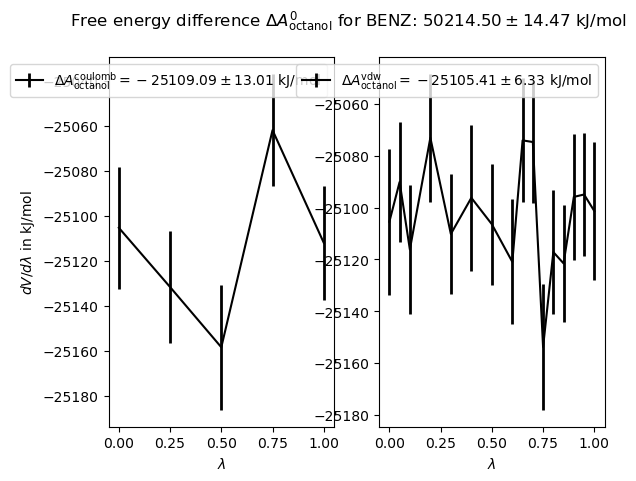

In [22]:
goct.collect()
goct.analyze()
goct.plot()

In [25]:
delta_G, p_OW = mdpow.fep.pOW(gwat, goct)
print(f"log P_ow = {p_OW.value} ± {p_OW.error}")

mdpow.fep   : INFO     [BENZ] transfer free energy water --> octanol calculation
mdpow.fep   : INFO     The solvent is water .
mdpow.fep   : INFO     Using already calculated free energy DeltaA
mdpow.fep   : INFO     The solvent is octanol .
mdpow.fep   : INFO     Using already calculated free energy DeltaA
mdpow.fep   : INFO     [BENZ] Values at T = 300 K
mdpow.fep   : INFO     [BENZ] Free energy of transfer water --> octanol: -17812.254 (15.182) kJ/mol
mdpow.fep   : INFO     [BENZ] log P_ow: 3101.325 (2.643)


log P_ow = 3101.324683550301 ± 2.643399588149987
